<a href="https://colab.research.google.com/github/debanilvb/Lung-disease-classification-using-chest-x-ray/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import keras
from tensorflow.keras.models import Sequential, Model
from collections import Counter
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [2]:
train_datagen = ImageDataGenerator ( rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(
rescale=1./255)


In [3]:
train_generator = train_datagen.flow_from_directory( '/content/drive/MyDrive/train', target_size=(224, 224),
batch_size=32, class_mode='categorical')


val_generator = val_datagen.flow_from_directory ( '/content/drive/MyDrive/val', target_size=(224, 224),
batch_size=32, class_mode='categorical')

Found 6480 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [4]:
val_generator.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2, 'TURBERCULOSIS': 3}

In [5]:
from tensorflow.keras.applications import VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [6]:
for layer in base_model.layers:
    layer.trainable = False

In [7]:
from tensorflow.keras import layers, models

In [8]:
# Build a custom CNN model on top of VGG19
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

In [40]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='accuracy', mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=3, min_lr=0.0001, verbose=1)

In [12]:
history = model.fit( train_generator, epochs=20,
validation_data=val_generator, callbacks=[checkpoint, reduce_lr]
)

Epoch 1/20
203/203 [==============================] - ETA: 0s - loss: 1.1949 - accuracy: 0.6782
Epoch 1: accuracy improved from -inf to 0.67824, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


203/203 [==============================] - 768s 3s/step - loss: 1.1949 - accuracy: 0.6782 - val_loss: 0.7807 - val_accuracy: 0.6053 - lr: 0.0010
Epoch 2/20
203/203 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.7633
Epoch 2: accuracy improved from 0.67824 to 0.76327, saving model to best_model.h5
203/203 [==============================] - 171s 843ms/step - loss: 0.5827 - accuracy: 0.7633 - val_loss: 0.6833 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 3/20
203/203 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.7815
Epoch 3: accuracy improved from 0.76327 to 0.78148, saving model to best_model.h5
203/203 [==============================] - 168s 827ms/step - loss: 0.5417 - accuracy: 0.7815 - val_loss: 0.7031 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 4/20
203/203 [==============================] - ETA: 0s - loss: 0.5324 - accuracy: 0.7986
Epoch 4: accuracy improved from 0.78148 to 0.79861, saving model to best_model.h5
203/203 [================

In [14]:
test_generator = test_datagen.flow_from_directory( '/content/drive/MyDrive/test', target_size=(224, 224),
batch_size=2, class_mode='categorical')

Found 771 images belonging to 4 classes.


In [15]:
eval_result = model.evaluate(test_generator)
print(f'Test Accuracy: {eval_result[1]}')

386/386 [==============================] - 133s 342ms/step - loss: 0.3687 - accuracy: 0.8923
Test Accuracy: 0.8923475742340088


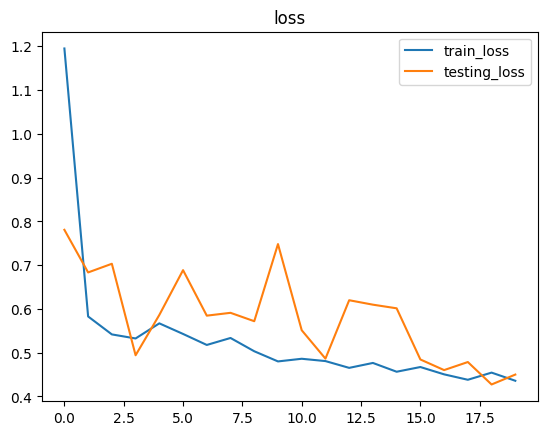

In [21]:
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

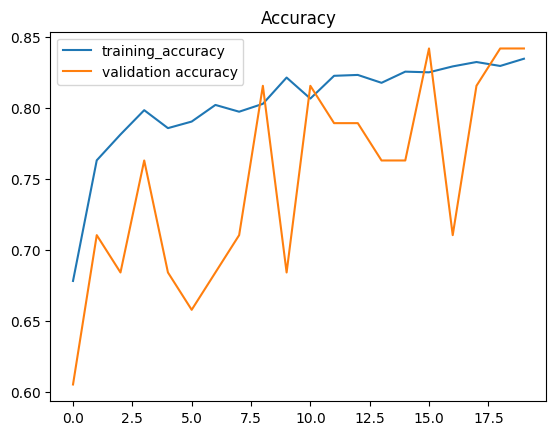

In [22]:
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [23]:
model.save("Detection_lung.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<ipython-input-24-ffb3f5b94948>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_data)


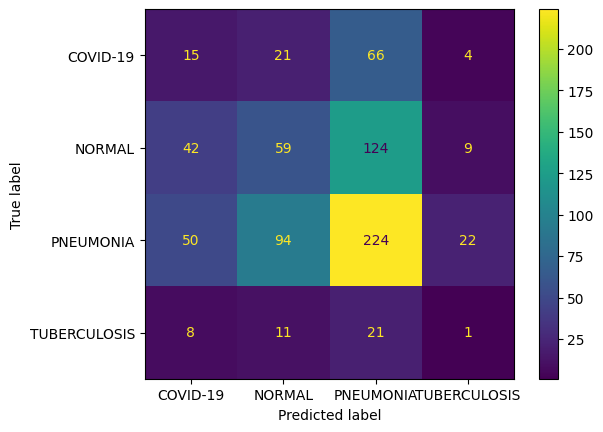

In [24]:
import numpy
from sklearn import metrics
from matplotlib import cm
test_data=test_generator
Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred ,axis =1)
confusion_matrix = metrics.confusion_matrix(test_data.classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['COVID-19','NORMAL','PNEUMONIA', 'TUBERCULOSIS'])
cm_display.plot()
plt.show()


using grid search to optimize


In [25]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD

In [26]:
# Define hyperparameters for grid search
param_grid = {
    'epochs': [10, 20],
    'batch_size': [32, 64],
    'dense_units': [256, 512],
    'dropout_rate': [0.3, 0.5]
}

In [27]:
def create_model(dense_units=256, dropout_rate=0.3):
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [57]:
from scikeras.wrappers import KerasClassifier
# Wrap the Keras model for use with GridSearchCV
k_model = KerasClassifier(build_fn=create_model, epochs=10,dense_units=256,dropout_rate=0.3, batch_size=32, verbose=0)
k_model.pickler = 'pickle'

In [43]:
create_model()

In [54]:
import joblib
joblib.parallel.BACKEND = 'multiprocessing'

In [58]:
grid = GridSearchCV(estimator=k_model, param_grid=param_grid, cv=10, n_jobs=1)

In [ ]:
grid_result = grid.fit(train_generator, validation_data=val_generator)
print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)